### Flight Delay Prediction: A Machine Learning Approach

Flight delays are a common issue that can cause significant inconvenience to passengers and operational challenges to airlines. Predicting flight delays is a complex task due to the multitude of factors involved, such as weather conditions, air traffic, and operational constraints. This notebook aims to explore and model flight delay predictions using various machine learning algorithms.

We will start by loading and preprocessing the data, including handling missing values, encoding categorical variables, and feature engineering. Following this, we will train and evaluate multiple regression models, including Linear Regression, Decision Trees, K-Nearest Neighbors (KNN), Random Forest, AdaBoost, and Bagging. For each model, we will perform hyperparameter tuning (commented out due to the long runtime) to optimize performance and compare the results using cross-validation and Root Mean Squared Error (RMSE).

Additionally, we will check for overfitting in the ensemble methods by comparing their performance on the training and validation datasets. If the model performs significantly better on the training data compared to the validation data, it may be overfitting.

By the end of this notebook, we aim to identify the most effective machine learning model for predicting flight delays and gain insights into the factors contributing to these delays.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df_train = pd.read_csv('data/Train.csv')
df_test = pd.read_csv('data/Test.csv') #This data is not used for modeling, but it is available (without the target) to check the models
                      
# Display first few rows
df_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [3]:
# Statistical summary of numerical features
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


In [4]:
# Check for missing values
print(df_train.isnull().sum())

ID        0
DATOP     0
FLTID     0
DEPSTN    0
ARRSTN    0
STD       0
STA       0
STATUS    0
AC        0
target    0
dtype: int64


- ID
- DATOP - Date of flight
- FLTID - Flight number
- DEPSTN - Departure point
- ARRSTN - Arrival point
- STD - Scheduled Time departure
- STA - Scheduled Time arrival
- STATUS - Flight status
- AC - Aircraft Code
- target - delay in minutes

### Changing the names of the columns for train and test data


In [5]:
# Renaming columns for train and test data
df_train = df_train.rename(columns={'ID': 'id', 'DATOP': 'date_of_flight', 'FLTID': 'flight_number', 'DEPSTN': 'departure_point',
                                    'ARRSTN': 'arrival_point', 'STD': 'scheduled_time_departure', 'STA': 'scheduled_time_arrival',
                                    'STATUS': 'flight_status', 'AC': 'aircraft_code', 'target': 'flight_delay'})

df_test = df_test.rename(columns={'ID': 'id', 'DATOP': 'date_of_flight', 'FLTID': 'flight_number', 'DEPSTN': 'departure_point',
                                  'ARRSTN': 'arrival_point', 'STD': 'scheduled_time_departure', 'STA': 'scheduled_time_arrival',
                                  'STATUS': 'flight_status', 'AC': 'aircraft_code'})

Text(0, 0.5, 'Frequeny')

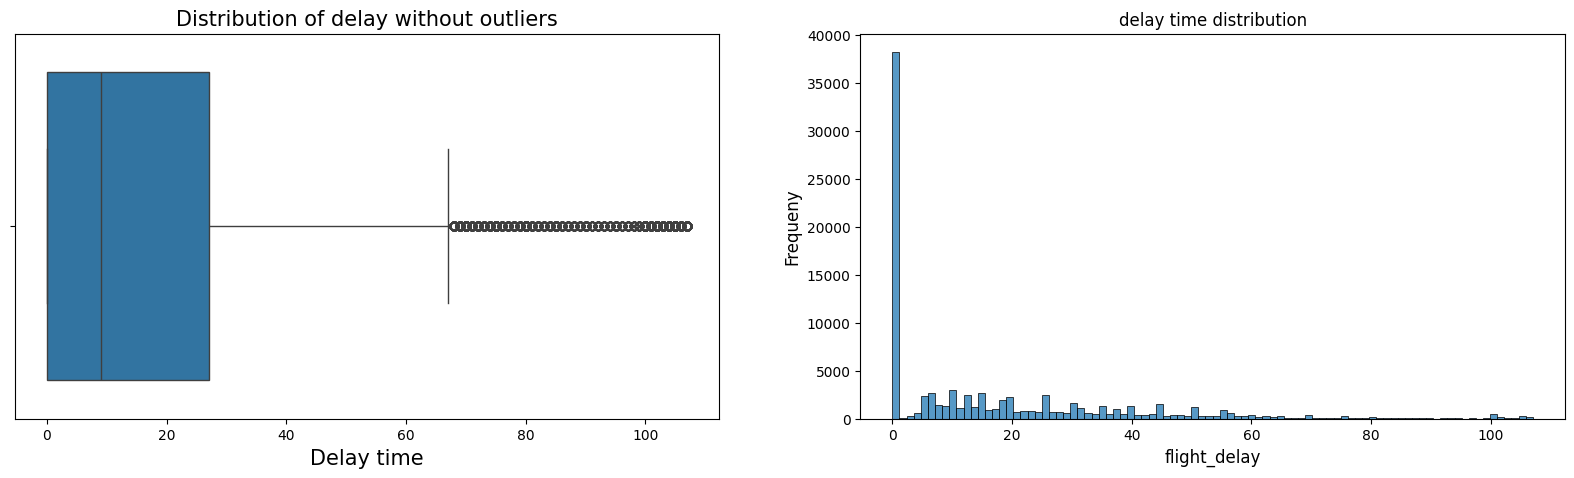

In [6]:
# Removing outliers
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
df_1=df_train.copy()
#Setting the quantile range
Q1 = df_1['flight_delay'].quantile(0.25)
Q3 = df_1['flight_delay'].quantile(0.75)
IQR = Q3 - Q1
#Roming the outliers
df_no_outliers = df_1[(df_1['flight_delay'] > (Q1 - 1.5 * IQR)) & (df_1['flight_delay'] < (Q3 + 1.5 * IQR))]
g2=sns.boxplot(x=df_no_outliers["flight_delay"])
g2.set_xlabel("Delay time",fontsize=15)
g2.set_title('Distribution of delay without outliers', fontsize=15);
plt.subplot(1,2,2)
f1 = 12
g1 = sns.histplot(data=df_no_outliers, x= "flight_delay")
g1.set_title("delay time distribution", fontsize = f1)
g1.set_xlabel("flight_delay", fontsize= f1)
g1.set_ylabel("Frequeny", fontsize=f1)

In [7]:
df_train = df_no_outliers

### Converting date strings into datetime


In [8]:
df_train['date_of_flight'] = pd.to_datetime(df_train['date_of_flight'])
df_train['scheduled_time_departure'] = pd.to_datetime(df_train['scheduled_time_departure'], format='%Y-%m-%d %H:%M:%S')
df_train['scheduled_time_arrival'] = pd.to_datetime(df_train['scheduled_time_arrival'], format='%Y-%m-%d %H.%M.%S')

df_test['date_of_flight'] = pd.to_datetime(df_test['date_of_flight'])
df_test['scheduled_time_departure'] = pd.to_datetime(df_test['scheduled_time_departure'], format='%Y-%m-%d %H:%M:%S')
df_test['scheduled_time_arrival'] = pd.to_datetime(df_test['scheduled_time_arrival'], format='%Y-%m-%d %H.%M.%S')

In [9]:
df_train.head()

,id,date_of_flight,flight_number,departure_point,arrival_point,scheduled_time_departure,scheduled_time_arrival,flight_status,aircraft_code,flight_delay
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0
5,train_id_5,2016-01-17,TU 0283,TLS,TUN,2016-01-17 16:20:00,2016-01-17 18:15:00,ATA,TU 736IOP,53.0


### Creating new features from the datetime objects

In [10]:
# Departure features
df_train['flight_year'] = pd.DatetimeIndex(df_train['date_of_flight']).year
df_train['departure_month'] = pd.DatetimeIndex(df_train['scheduled_time_departure']).month
df_train['departure_day'] = pd.DatetimeIndex(df_train['scheduled_time_departure']).day
df_train['departure_hour'] = pd.DatetimeIndex(df_train['scheduled_time_departure']).hour
df_train['departure_minute'] = pd.DatetimeIndex(df_train['scheduled_time_departure']).minute

df_test['flight_year'] = pd.DatetimeIndex(df_test['date_of_flight']).year
df_test['departure_month'] = pd.DatetimeIndex(df_test['scheduled_time_departure']).month
df_test['departure_day'] = pd.DatetimeIndex(df_test['scheduled_time_departure']).day
df_test['departure_hour'] = pd.DatetimeIndex(df_test['scheduled_time_departure']).hour
df_test['departure_minute'] = pd.DatetimeIndex(df_test['scheduled_time_departure']).minute

In [11]:
# Arrival features
df_train['arrival_month'] = pd.DatetimeIndex(df_train['scheduled_time_arrival']).month
df_train['arrival_day'] = pd.DatetimeIndex(df_train['scheduled_time_arrival']).day
df_train['arrival_hour'] = pd.DatetimeIndex(df_train['scheduled_time_arrival']).hour
df_train['arrival_minute'] = pd.DatetimeIndex(df_train['scheduled_time_arrival']).minute

df_test['arrival_month'] = pd.DatetimeIndex(df_test['scheduled_time_arrival']).month
df_test['arrival_day'] = pd.DatetimeIndex(df_test['scheduled_time_arrival']).day
df_test['arrival_hour'] = pd.DatetimeIndex(df_test['scheduled_time_arrival']).hour
df_test['arrival_minute'] = pd.DatetimeIndex(df_test['scheduled_time_arrival']).minute

In [12]:
df_train.head()

,id,date_of_flight,flight_number,departure_point,arrival_point,scheduled_time_departure,scheduled_time_arrival,flight_status,aircraft_code,flight_delay,flight_year,departure_month,departure_day,departure_hour,departure_minute,arrival_month,arrival_day,arrival_hour,arrival_minute
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,2016,1,13,15,5,1,13,16,55
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,2016,1,16,4,10,1,16,6,45
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,2016,1,17,14,10,1,17,17,0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,2016,1,17,14,30,1,17,15,50
5,train_id_5,2016-01-17,TU 0283,TLS,TUN,2016-01-17 16:20:00,2016-01-17 18:15:00,ATA,TU 736IOP,53.0,2016,1,17,16,20,1,17,18,15


## Deleting columns

In [13]:
df_train = df_train.drop(columns=['id', 'scheduled_time_departure', 'scheduled_time_arrival', 'date_of_flight'])
df_test = df_test.drop(columns=['id', 'scheduled_time_departure', 'scheduled_time_arrival', 'date_of_flight'])

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93225 entries, 1 to 107832
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   flight_number     93225 non-null  object 
 1   departure_point   93225 non-null  object 
 2   arrival_point     93225 non-null  object 
 3   flight_status     93225 non-null  object 
 4   aircraft_code     93225 non-null  object 
 5   flight_delay      93225 non-null  float64
 6   flight_year       93225 non-null  int32  
 7   departure_month   93225 non-null  int32  
 8   departure_day     93225 non-null  int32  
 9   departure_hour    93225 non-null  int32  
 10  departure_minute  93225 non-null  int32  
 11  arrival_month     93225 non-null  int32  
 12  arrival_day       93225 non-null  int32  
 13  arrival_hour      93225 non-null  int32  
 14  arrival_minute    93225 non-null  int32  
dtypes: float64(1), int32(9), object(5)
memory usage: 8.2+ MB


### Encoding features (ordinal encoding method)


In [15]:
label_encoder = LabelEncoder()

In [16]:
#encoding departures features
df_train['flight_year'] = label_encoder.fit_transform(df_train['flight_year'])
df_train['departure_month'] = label_encoder.fit_transform(df_train['departure_month'])
df_train['departure_day'] = label_encoder.fit_transform(df_train['departure_day'])
df_train['departure_hour'] = label_encoder.fit_transform(df_train['departure_hour'])
df_train['departure_minute'] = label_encoder.fit_transform(df_train['departure_minute'])

df_test['flight_year'] = label_encoder.fit_transform(df_test['flight_year'])
df_test['departure_month'] = label_encoder.fit_transform(df_test['departure_month'])
df_test['departure_day'] = label_encoder.fit_transform(df_test['departure_day'])
df_test['departure_hour'] = label_encoder.fit_transform(df_test['departure_hour'])
df_test['departure_minute'] = label_encoder.fit_transform(df_test['departure_minute'])

In [17]:
#encoding arrival features
df_train['arrival_month'] = label_encoder.fit_transform(df_train['arrival_month'])
df_train['arrival_day'] = label_encoder.fit_transform(df_train['arrival_day'])
df_train['arrival_hour'] = label_encoder.fit_transform(df_train['arrival_hour'])
df_train['arrival_minute'] = label_encoder.fit_transform(df_train['arrival_minute'])

df_test['arrival_month'] = label_encoder.fit_transform(df_test['arrival_month'])
df_test['arrival_day'] = label_encoder.fit_transform(df_test['arrival_day'])
df_test['arrival_hour'] = label_encoder.fit_transform(df_test['arrival_hour'])
df_test['arrival_minute'] = label_encoder.fit_transform(df_test['arrival_minute'])

In [18]:
#encoding rest of variables 
df_train['flight_number'] = label_encoder.fit_transform(df_train['flight_number'])
df_test['flight_number'] = label_encoder.fit_transform(df_test['flight_number'])

df_train['departure_point'] = label_encoder.fit_transform(df_train['departure_point'])
df_train['arrival_point'] = label_encoder.fit_transform(df_train['arrival_point'])
df_train['flight_status'] = label_encoder.fit_transform(df_train['flight_status'])
df_train['aircraft_code'] = label_encoder.fit_transform(df_train['aircraft_code'])

df_test['departure_point'] = label_encoder.fit_transform(df_test['departure_point'])
df_test['arrival_point'] = label_encoder.fit_transform(df_test['arrival_point'])
df_test['flight_status'] = label_encoder.fit_transform(df_test['flight_status'])
df_test['aircraft_code'] = label_encoder.fit_transform(df_test['aircraft_code'])

In [19]:
df_train.shape

(93225, 15)

In [20]:
df_test.shape

(9333, 14)

In [21]:
df_train.sort_values(by=['flight_number']).head(10)

,flight_number,departure_point,arrival_point,flight_status,aircraft_code,flight_delay,flight_year,departure_month,departure_day,departure_hour,departure_minute,arrival_month,arrival_day,arrival_hour,arrival_minute
32088,0,118,115,4,42,0.0,0,3,10,0,0,6,15,7,0
31438,1,118,115,4,38,0.0,0,3,13,7,0,3,20,12,0
69749,1,118,115,4,45,0.0,1,0,23,0,0,0,25,1,0
104798,1,118,115,4,35,0.0,2,2,26,5,0,2,27,20,0
104921,1,118,115,4,31,0.0,2,9,8,7,0,9,10,14,0
30915,1,118,115,4,35,0.0,0,7,1,6,0,7,3,5,0
107196,1,118,115,4,44,0.0,2,3,23,7,0,3,25,16,20
105184,1,118,115,4,29,0.0,2,4,13,14,0,4,18,15,30
104325,1,118,115,4,28,0.0,2,1,19,7,0,1,20,20,0
107633,1,118,115,4,42,0.0,2,11,10,7,0,11,13,14,0


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93225 entries, 1 to 107832
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   flight_number     93225 non-null  int64  
 1   departure_point   93225 non-null  int64  
 2   arrival_point     93225 non-null  int64  
 3   flight_status     93225 non-null  int64  
 4   aircraft_code     93225 non-null  int64  
 5   flight_delay      93225 non-null  float64
 6   flight_year       93225 non-null  int64  
 7   departure_month   93225 non-null  int64  
 8   departure_day     93225 non-null  int64  
 9   departure_hour    93225 non-null  int64  
 10  departure_minute  93225 non-null  int64  
 11  arrival_month     93225 non-null  int64  
 12  arrival_day       93225 non-null  int64  
 13  arrival_hour      93225 non-null  int64  
 14  arrival_minute    93225 non-null  int64  
dtypes: float64(1), int64(14)
memory usage: 11.4 MB


In [23]:
#converting flight delay into int64 type
df_train['flight_delay'] = df_train['flight_delay'].astype('int64')

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93225 entries, 1 to 107832
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   flight_number     93225 non-null  int64
 1   departure_point   93225 non-null  int64
 2   arrival_point     93225 non-null  int64
 3   flight_status     93225 non-null  int64
 4   aircraft_code     93225 non-null  int64
 5   flight_delay      93225 non-null  int64
 6   flight_year       93225 non-null  int64
 7   departure_month   93225 non-null  int64
 8   departure_day     93225 non-null  int64
 9   departure_hour    93225 non-null  int64
 10  departure_minute  93225 non-null  int64
 11  arrival_month     93225 non-null  int64
 12  arrival_day       93225 non-null  int64
 13  arrival_hour      93225 non-null  int64
 14  arrival_minute    93225 non-null  int64
dtypes: int64(15)
memory usage: 11.4 MB


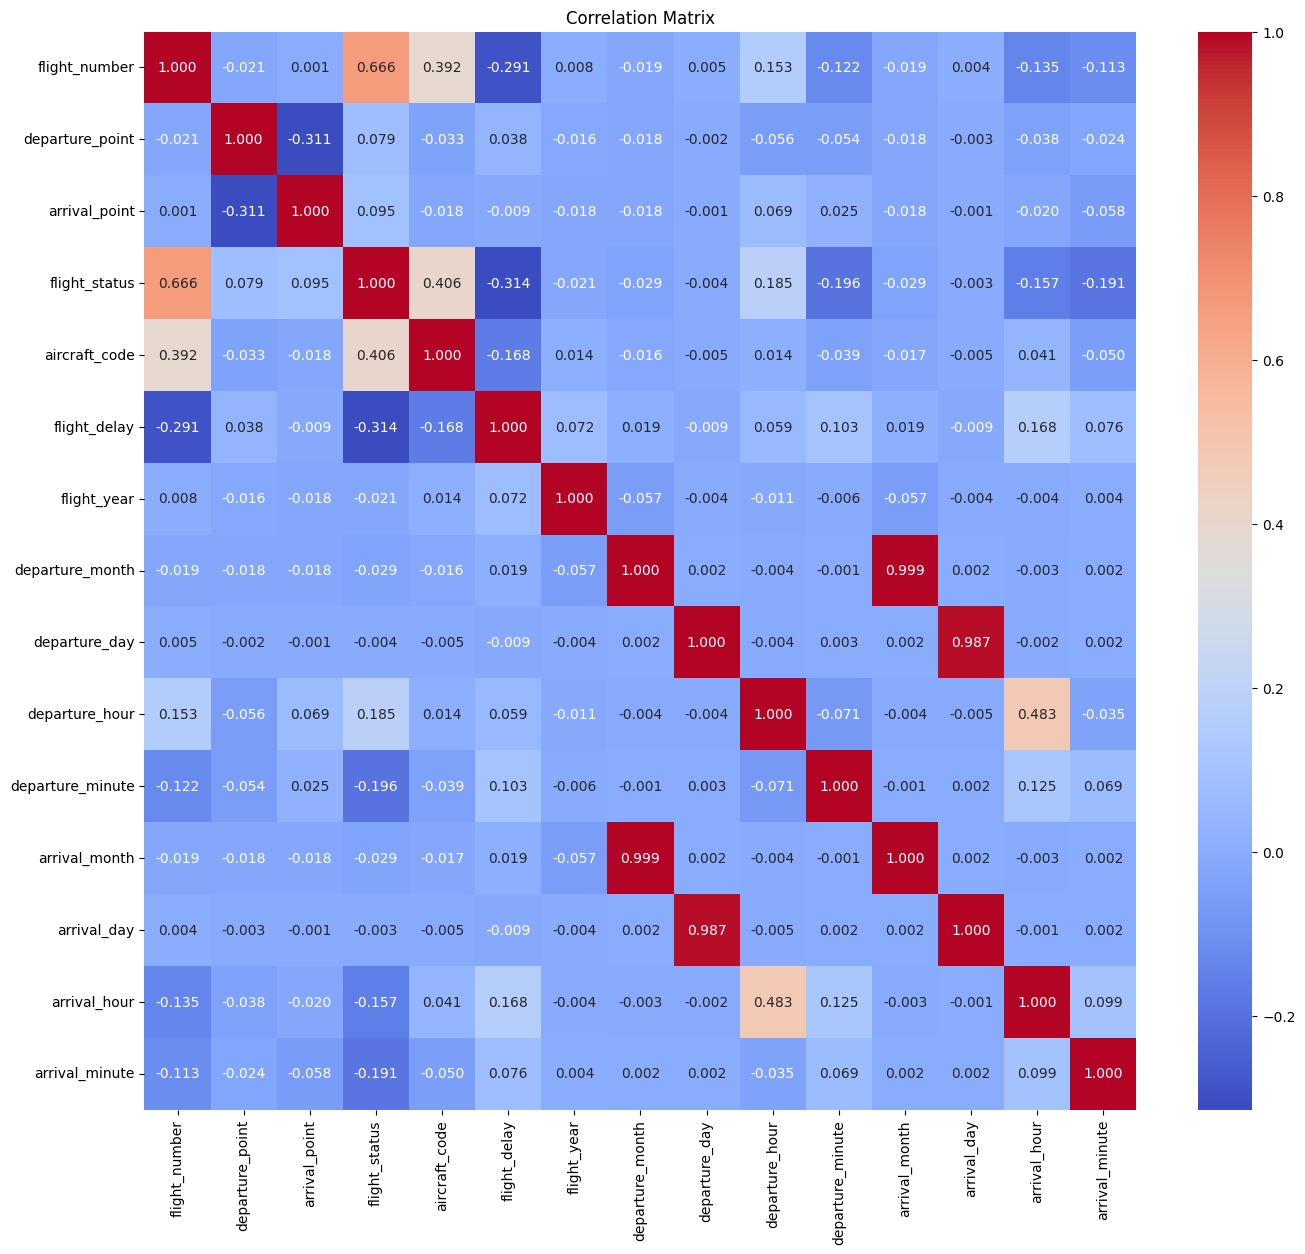

In [25]:
# Compute and plot correlation matrix
correlation_matrix = df_train.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f").set(title='Correlation Matrix')
plt.show()

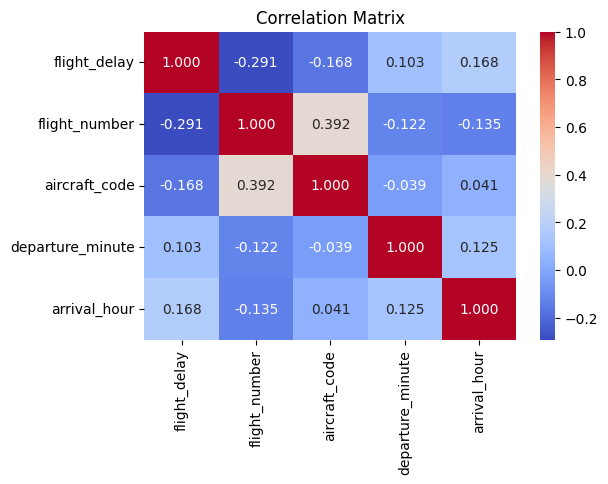

In [26]:
# Plot correlation matrix for selected features
df_corr = df_train[['flight_delay', 'flight_number', 'aircraft_code', 'departure_minute', 'arrival_hour']]
plt.figure(figsize=(6, 4))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".3f").set(title='Correlation Matrix')
plt.show()

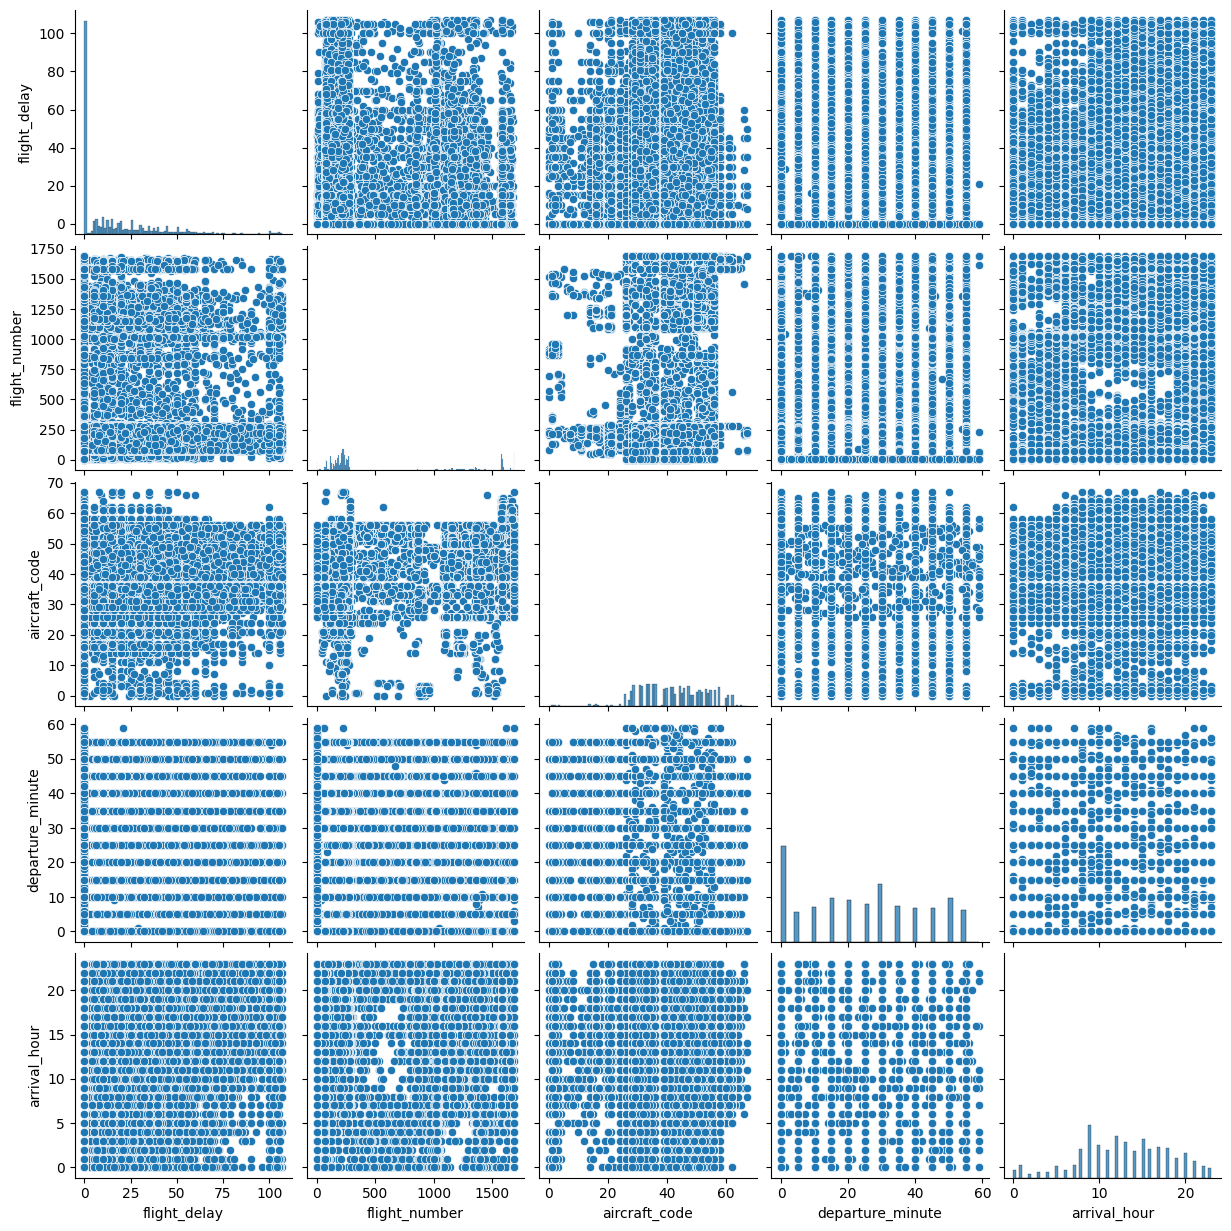

In [27]:
# Plotting pairplot for selected features
sns.pairplot(df_corr)
plt.show()

## Column transformation

In [28]:
#Creating lists of numerical and categorical features
numerical_list = ['flight_number', 'departure_point', 'arrival_point', 'aircraft_code', 'departure_month', 'departure_day', 
                  'departure_hour', 'departure_minute', 'arrival_month', 'arrival_day', 'arrival_hour', 'arrival_minute']
categorical_list = ['flight_status', 'flight_year']

#Creating pipeline for numerical and categorical processing
numeric_transformer = Pipeline(steps=[('normalizer', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

#Defining the transformer
transformer = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_list),
    ('cat', categorical_transformer, categorical_list)
])

## Data preparation

In [29]:
#Define X (all features without the target) and y (flight delay value)
X = df_train.drop(['flight_delay'], axis=1)
y = df_train['flight_delay']

In [30]:
#Divide data for training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [31]:
#Check sizes of the samples
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((74580, 14), (18645, 14), (74580,), (18645,))

## Choosing and training some regression models

### Linear regression model

In [32]:
# Call and save the model in a variable
linear_regression =LinearRegression()

In [33]:
#Pipeline of the whole prediction
model_linear_regression = Pipeline([
    ('transformer', transformer),
    ('linear_regression', linear_regression)
])

In [34]:
#Fit model with training data
model_linear_regression.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  ['flight_number',
                                                   'departure_point',
                                                   'arrival_point',
                                                   'aircraft_code',
                                                   'departure_month',
                                                   'departure_day',
                                                   'departure_hour',
                                                   'departure_minute',
                                                   'arrival_month',
                                                   'arrival_day',
                                                   'arrival_hour',
                                                   'arrival_minute']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['flight_status',
                                                   'flight_year'])])),
                ('linear_regression', LinearRegression())])

#### Linear regression model evaluation

In [35]:
#Evaluate the model with cross validation
linear_scores=cross_val_score(model_linear_regression, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
linear_scores

array([-429.84431776, -433.76004424, -415.62599853, -425.96887391,
       -432.52796769, -429.81872811, -438.92487978, -425.76632986,
       -420.15890951, -421.45396381])

In [36]:
#Change sign and obtaining squared root
linear_rmse_scores=np.sqrt(-linear_scores)
linear_rmse_scores

array([20.73268718, 20.82690674, 20.38690753, 20.63901339, 20.79730674,
       20.73207004, 20.95053412, 20.63410599, 20.49777816, 20.52934397])

In [37]:
#Define a function to calculate mean and std
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())

In [38]:
display_scores(linear_rmse_scores)

Scores: [20.73268718 20.82690674 20.38690753 20.63901339 20.79730674 20.73207004
 20.95053412 20.63410599 20.49777816 20.52934397]
Mean: 20.672665385425752
Standard Deviation: 0.1609570843185316


In [39]:
model_linear_regression.score(X_test, y_test)

0.1469702106197166

### Other evaluation metrics for linear regression model

In [40]:
#Calculate RMSE. The delay result is in minutes. 
y_hat = model_linear_regression.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 20.60267291615122


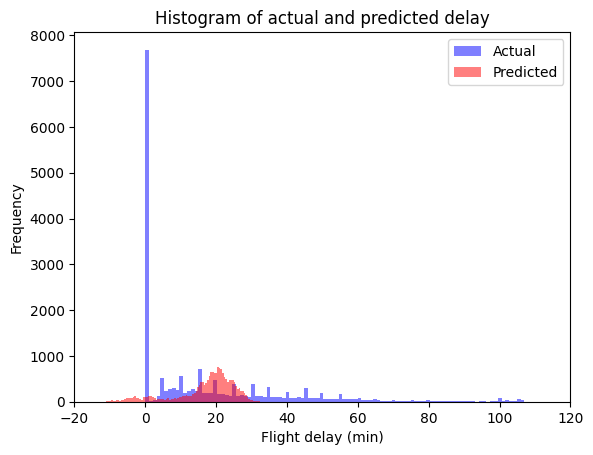

In [41]:
# Plot predicted vs actual values
y_hat = model_linear_regression.predict(X_test)

# Plot the histogram
plt.hist(y_test, bins=100, alpha=0.5, color='blue', label='Actual')
plt.hist(y_hat, bins=100, alpha=0.5, color='red', label='Predicted')

# Add labels and legend
plt.xlabel('Flight delay (min)')
plt.ylabel('Frequency')
plt.xlim(-20, 120)

plt.title('Histogram of actual and predicted delay')
plt.legend()

# Show plot
plt.show()

### Decision Tree model

In [42]:
#variable for the model
tree_reg = DecisionTreeRegressor(random_state=42)

#define pipeline : transformation + modelling
model_tree_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('tree_reg', tree_reg)
])

#adjuste the model
model_tree_reg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  ['flight_number',
                                                   'departure_point',
                                                   'arrival_point',
                                                   'aircraft_code',
                                                   'departure_month',
                                                   'departure_day',
                                                   'departure_hour',
                                                   'departure_minute',
                                                   'arrival_month',
                                                   'arrival_day',
                                                   'arrival_hour',
                                                   'arrival_minute']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['flight_status',
                                                   'flight_year'])])),
                ('tree_reg', DecisionTreeRegressor(random_state=42))])

#### Decision Tree model evaluation

In [43]:
#evaluating the model with cross validation

#calculating score
tree_reg_scores=cross_val_score(model_tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
linear_scores

#changing sign and obtaining squared root
tree_rmse_scores=np.sqrt(-tree_reg_scores)

#showing the result by using the display_scores function
display_scores(tree_rmse_scores)

Scores: [26.15632605 26.64487662 26.1106111  26.54518201 25.98779031 26.34351328
 26.5847209  26.32260611 26.44133394 26.9604236 ]
Mean: 26.40973839254495
Standard Deviation: 0.2742661586475495


In [44]:
model_tree_reg.score(X_test, y_test)

-0.404045293482985

In [45]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_tree_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 26.4321218640804


### Hyperparameter Tuning on Decision Tree model

In [46]:
# max_depth = [2, 4, 6, 8, 10]
# min_samples_split = [2, 4, 6, 8, 10]
# min_samples_leaf = [1, 2, 4, 6, 8, 10]
 
# params={'tree_reg__max_depth': max_depth,
#         'tree_reg__min_samples_split': min_samples_split,
#         'tree_reg__min_samples_leaf': min_samples_leaf}
# print(params)

In [47]:
# # defining gridsearch
# grid_rand = GridSearchCV ( model_tree_reg, param_grid=params, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [48]:
# #adjusting model by using all possible parameters
# grid_rand.fit(X, y)

In [49]:
# #Showing the best combination of parameters
# grid_rand.best_params_

### Using the best parameters found

In [50]:
#variable for the model
tree_reg = DecisionTreeRegressor(random_state=42, max_depth= 8, min_samples_leaf= 8, min_samples_split= 2)

#defiying pipeline : transformation + modelling
model_tree_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('tree_reg', tree_reg)
])

#adjusting the model
model_tree_reg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  ['flight_number',
                                                   'departure_point',
                                                   'arrival_point',
                                                   'aircraft_code',
                                                   'departure_month',
                                                   'departure_day',
                                                   'departure_hour',
                                                   'departure_minute',
                                                   'arrival_month',
                                                   'arrival_day',
                                                   'arrival_hour',
                                                   'arrival_minute']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['flight_status',
                                                   'flight_year'])])),
                ('tree_reg',
                 DecisionTreeRegressor(max_depth=8, min_samples_leaf=8,
                                       random_state=42))])

In [51]:
#evaluating the model with cross validation

#calculating score
tree_reg_scores=cross_val_score(model_tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
linear_scores

#changing sign and obtaining squared root
tree_rmse_scores=np.sqrt(-tree_reg_scores)

#showing the result by using the display_scores function
display_scores(tree_rmse_scores)

Scores: [19.52846486 19.84207551 19.3304348  19.62884952 19.59039811 19.7292211
 19.81787868 19.44940096 19.58005055 19.5598133 ]
Mean: 19.60565873782327
Standard Deviation: 0.15028297775265753


In [52]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_tree_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 19.614244492302845


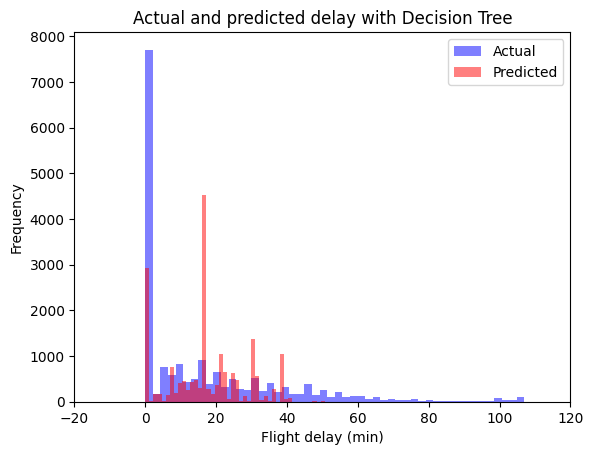

In [53]:
# # Plot predicted vs actual values
y_hat = model_tree_reg.predict(X_test)

# Plot the histograms
plt.hist(y_test, bins=50, alpha=0.5, color='blue', label='Actual')
plt.hist(y_hat, bins=50, alpha=0.5, color='red', label='Predicted')

# Add labels and legend
plt.xlabel('Flight delay (min)')
plt.ylabel('Frequency')
plt.xlim(-20, 120)

plt.title('Actual and predicted delay with Decision Tree')
plt.legend()

# Show plot
plt.show()

### KNN model

In [54]:
#variable for the model
knn_reg = KNeighborsRegressor()

#defiying pipeline : transformation + modelling
model_knn_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('knn_reg', knn_reg)
])

#adjusting the model
model_knn_reg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  ['flight_number',
                                                   'departure_point',
                                                   'arrival_point',
                                                   'aircraft_code',
                                                   'departure_month',
                                                   'departure_day',
                                                   'departure_hour',
                                                   'departure_minute',
                                                   'arrival_month',
                                                   'arrival_day',
                                                   'arrival_hour',
                                                   'arrival_minute']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['flight_status',
                                                   'flight_year'])])),
                ('knn_reg', KNeighborsRegressor())])

#### KNN model evaluation

In [55]:
#evaluating the model with cross validation

#calculating score
knn_reg_scores=cross_val_score(model_knn_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

#changing sign and obtaining squared root
knn_rmse_scores=np.sqrt(-knn_reg_scores)

#showing the result by using the display_scores function
display_scores(knn_rmse_scores)

Scores: [20.28580913 20.89253043 20.05266611 20.48721818 20.50494672 20.64825
 20.73335135 20.5573684  20.36689035 20.2942286 ]
Mean: 20.482325927909244
Standard Deviation: 0.2317135496964042


In [56]:
model_knn_reg.score(X_test, y_test)

0.16000082876481703

In [57]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_knn_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 20.444707319696207


### Hyperparameter Tuning on KNN model

In [58]:
# params={
#     'knn_reg__n_neighbors': [3, 5, 7],
#     'knn_reg__weights': ['uniform', 'distance'],
#     'knn_reg__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'knn_reg__leaf_size': [20, 30, 40],
#     'knn_reg__p': [1, 2]  # For Manhattan and Euclidean distance
# }

In [59]:
# grid_rand = GridSearchCV ( model_knn_reg, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [60]:
#adjusting the model
# grid_rand.fit(X, y)

In [61]:
#Showing the best combination of parameters
# grid_rand.best_params_

### Using the best parameters found

In [62]:
#variable for the model
knn_reg = KNeighborsRegressor(algorithm= 'kd_tree', leaf_size=20, n_neighbors= 7, p= 1, weights= 'uniform')

#defiying pipeline : transformation + modelling
model_knn_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('knn_reg', knn_reg)
])

#adjusting the model
model_knn_reg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  ['flight_number',
                                                   'departure_point',
                                                   'arrival_point',
                                                   'aircraft_code',
                                                   'departure_month',
                                                   'departure_day',
                                                   'departure_hour',
                                                   'departure_minute',
                                                   'arrival_month',
                                                   'arrival_day',
                                                   'arrival_hour',
                                                   'arrival_minute']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['flight_status',
                                                   'flight_year'])])),
                ('knn_reg',
                 KNeighborsRegressor(algorithm='kd_tree', leaf_size=20,
                                     n_neighbors=7, p=1))])

In [63]:
#calculating score
knn_reg_scores=cross_val_score(model_knn_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

#changing sign and obtaining squared root
knn_rmse_scores=np.sqrt(-knn_reg_scores)

#showing the result by using the display_scores function
display_scores(knn_rmse_scores)

Scores: [19.60346386 20.09905487 19.35084465 19.82478408 19.700392   19.91805314
 19.99626554 19.79606065 19.49484795 19.64019698]
Mean: 19.74239637001461
Standard Deviation: 0.21869659928382437


In [64]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_knn_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 19.621826071041465


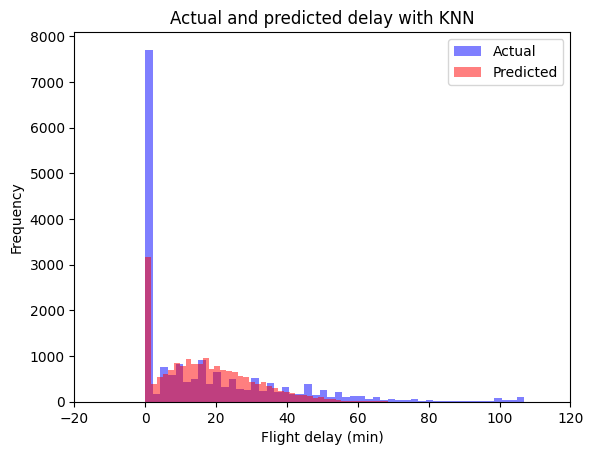

In [65]:
# # Plot predicted vs actual values
y_hat = model_knn_reg.predict(X_test)

# Plot the histograms
plt.hist(y_test, bins=50, alpha=0.5, color='blue', label='Actual')
plt.hist(y_hat, bins=50, alpha=0.5, color='red', label='Predicted')

# Add labels and legend
plt.xlabel('Flight delay (min)')
plt.ylabel('Frequency')
plt.xlim(-20, 120)

plt.title('Actual and predicted delay with KNN')
plt.legend()

# Show plot
plt.show()

### Ensemble method: RandomForest model

In [66]:
#variable for the model
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)

#defiying pipeline : transformation + modelling
model_forest_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('forest_reg', forest_reg)
])

#adjusting the model
model_forest_reg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  ['flight_number',
                                                   'departure_point',
                                                   'arrival_point',
                                                   'aircraft_code',
                                                   'departure_month',
                                                   'departure_day',
                                                   'departure_hour',
                                                   'departure_minute',
                                                   'arrival_month',
                                                   'arrival_day',
                                                   'arrival_hour',
                                                   'arrival_minute']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['flight_status',
                                                   'flight_year'])])),
                ('forest_reg',
                 RandomForestRegressor(n_estimators=10, random_state=42))])

#### RandomForest model evaluation

In [67]:
#evaluating the model with cross validation

#calculating score
forest_reg_scores=cross_val_score(model_forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

#changing sign and obtaining squared root
forest_rmse_scores=np.sqrt(-forest_reg_scores)

#showing the result by using the display_scores function
display_scores(forest_rmse_scores)

Scores: [19.6395233  20.28809882 19.56005299 20.06851315 19.72194441 19.99119922
 19.89758297 19.87464001 19.70296954 19.79669597]
Mean: 19.854122037204625
Standard Deviation: 0.20773645906497804


In [68]:
model_forest_reg.score(X_test, y_test)

0.21383388539872317

In [69]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_knn_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 19.621826071041465


### Hyperparameter Tuning on RandomForest model

In [70]:
# n_estimators = [3, 10, 30, 50, 80, 100]
# min_samples_split = [2, 4, 6, 8]
# max_depth = [2, 4, 6, 8, 10]
 
# params={'forest_reg__n_estimators': n_estimators,
#         'forest_reg__min_samples_split': min_samples_split,
#         'forest_reg__max_depth': max_depth}
# print(params)

In [71]:
# defining gridsearch
#grid_rand = GridSearchCV ( model_forest_reg, param_grid=params, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [72]:
#adjusting model by using all possible parameters 
#grid_rand.fit(X, y)

In [73]:
#Showing the best combination of parameters
#grid_rand.best_params_

### Using the best parameters found

In [74]:
#Adjusting the model with the best parameters
forest_reg = RandomForestRegressor( random_state=42, max_depth= 10, min_samples_split= 8, n_estimators= 80)

In [75]:
#defining pipeline
model_forest_reg = Pipeline(steps=[
    ('transformer', transformer),
    ('forest_reg', forest_reg)
])

In [76]:
#adjusting the model
model_forest_reg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('normalizer',
                                                                   MinMaxScaler())]),
                                                  ['flight_number',
                                                   'departure_point',
                                                   'arrival_point',
                                                   'aircraft_code',
                                                   'departure_month',
                                                   'departure_day',
                                                   'departure_hour',
                                                   'departure_minute',
                                                   'arrival_month',
                                                   'arrival_day',
                                                   'arrival_hour',
                                                   'arrival_minute']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['flight_status',
                                                   'flight_year'])])),
                ('forest_reg',
                 RandomForestRegressor(max_depth=10, min_samples_split=8,
                                       n_estimators=80, random_state=42))])

In [77]:
#evaluating the model. Calculating score with CV
forest_reg_scores=cross_val_score(model_forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

In [78]:
forest_rmse_scores=np.sqrt(- forest_reg_scores)

In [79]:
#showing results thought display_scores function
display_scores(forest_rmse_scores)

Scores: [18.9608339  19.29693037 18.76414721 19.10846733 18.99911614 19.15864805
 19.2769528  18.98415415 18.96863759 18.9578073 ]
Mean: 19.04756948420534
Standard Deviation: 0.15471022011834523


In [80]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_forest_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 19.025713769113164


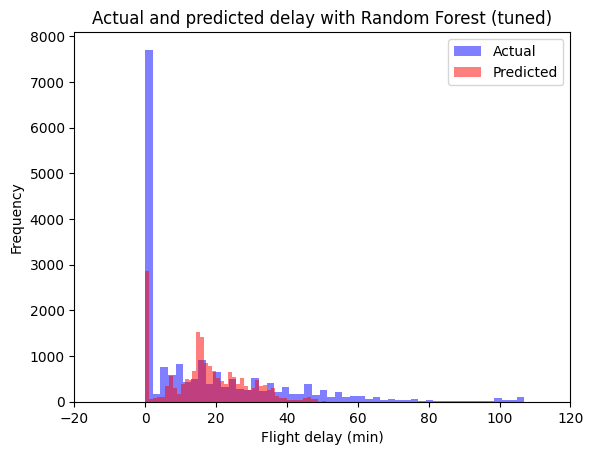

In [81]:
# # Plot predicted vs actual values
y_hat = model_forest_reg.predict(X_test)

# Plot the histograms
plt.hist(y_test, bins=50, alpha=0.5, color='blue', label='Actual')
plt.hist(y_hat, bins=50, alpha=0.5, color='red', label='Predicted')

# Add labels and legend
plt.xlabel('Flight delay (min)')
plt.ylabel('Frequency')
plt.xlim(-20, 120)

plt.title('Actual and predicted delay with Random Forest (tuned)')
plt.legend()

# Show plot
plt.show()

### Ensemble method: Boosting (Adaboosting)

In [82]:
#creating the base estimator model. We are using the hyperparametes found above in the decision tree section
decision_tree_regression2 = DecisionTreeRegressor(random_state=42, max_depth= 8, min_samples_leaf= 8, min_samples_split= 2)
#decision_tree_regression2 = DecisionTreeRegressor(random_state=42)

model_ada_reg = AdaBoostRegressor(decision_tree_regression2, n_estimators=10, random_state=42, learning_rate=0.05)
#Pipeline of the whole prediction

#adjusting the model
model_ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=8,
                                                  min_samples_leaf=8,
                                                  random_state=42),
                  learning_rate=0.05, n_estimators=10, random_state=42)

#### Boosting model evaluation

In [83]:
#evaluating the model with cross validation

#calculating score by using the new X data (which is called X2)
boosting_reg_scores=cross_val_score(model_ada_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

#changing sign and obtaining squared root
boosting_rmse_scores=np.sqrt(-boosting_reg_scores)

#showing the result by using the display_scores function
display_scores(boosting_rmse_scores)

Scores: [19.37455914 19.68363426 19.22495277 19.46036834 19.42966347 19.59184747
 19.76112617 19.31949045 19.42456632 19.41183945]
Mean: 19.46820478615599
Standard Deviation: 0.15626436754596118


In [84]:
model_ada_reg.score(X_test, y_test)

0.2365703599688017

In [85]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_ada_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 19.490634508136377


### Hyperparameter Tuning on Adaboosting model

In [86]:
# #Using a DecisionTreeRegressor with the best parameters found above in decision tree model section

# adaboost_regressor = AdaBoostRegressor(base_estimator=decision_tree_regression2, random_state=42)

# # Define hyperparameters to search
# params = {
#     'n_estimators': [10, 25, 50, 75, 100, 150, 200],  # Number of weak learners
#     'learning_rate': [0.01, 0.05, 0.1, 1.0]  # Learning rate
# }

In [87]:
# defining gridsearch
#grid_rand = GridSearchCV(adaboost_regressor, param_grid=params, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [88]:
#adjusting model by using all possible parameters 
#grid_rand.fit(X, y)

In [89]:
#Showing the best combination of parameters
#grid_rand.best_params_

### Using the best parameters found

In [90]:
#using best parameters
model_ada_reg = AdaBoostRegressor(decision_tree_regression2, n_estimators=25, random_state=42, learning_rate=0.01)
#Pipeline of the whole prediction

#adjusting the model
model_ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=8,
                                                  min_samples_leaf=8,
                                                  random_state=42),
                  learning_rate=0.01, n_estimators=25, random_state=42)

In [91]:
#evaluating the model with cross validation

#calculating score by using the new X (whoch is called X2)
boosting_reg_scores=cross_val_score(model_ada_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

#changing sign and obtaining squared root
boosting_rmse_scores=np.sqrt(-boosting_reg_scores)

#showing the result by using the display_scores function
display_scores(boosting_rmse_scores)

Scores: [19.36995767 19.68799923 19.20730479 19.47337842 19.43953769 19.56251544
 19.66551116 19.30013436 19.39045705 19.3986137 ]
Mean: 19.449540952632656
Standard Deviation: 0.1450364381856431


In [92]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_ada_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 19.436785987370325


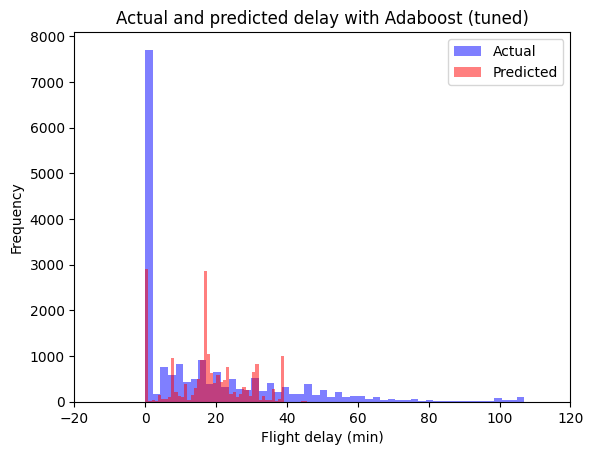

In [93]:
# # Plot predicted vs actual values
y_hat = model_ada_reg.predict(X_test)

# Plot the histograms
plt.hist(y_test, bins=50, alpha=0.5, color='blue', label='Actual')
plt.hist(y_hat, bins=50, alpha=0.5, color='red', label='Predicted')

# Add labels and legend
plt.xlabel('Flight delay (min)')
plt.ylabel('Frequency')
plt.xlim(-20, 120)

plt.title('Actual and predicted delay with Adaboost (tuned)')
plt.legend()

# Show plot
plt.show()

## Ensemble method: Bagging

In [94]:
#decision_tree_regression2 =DecisionTreeRegressor(max_depth=5)
bagging_reg = BaggingRegressor(knn_reg, n_estimators=10, random_state=42)

#adjusting the model
bagging_reg.fit(X_train, y_train) 

BaggingRegressor(estimator=KNeighborsRegressor(algorithm='kd_tree',
                                               leaf_size=20, n_neighbors=7,
                                               p=1),
                 random_state=42)

In [95]:
#evaluating the model with cross validation

#calculating score
bagging_reg_scores=cross_val_score(bagging_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

#changing sign and obtaining squared root
bagging_rmse_scores=np.sqrt(-bagging_reg_scores)

#showing the result by using the display_scores function
display_scores(bagging_rmse_scores)

Scores: [19.80443589 20.41683227 19.60666066 20.01022104 19.88186972 20.10313659
 20.11123489 19.92589481 19.72461926 19.89892619]
Mean: 19.94838313092631
Standard Deviation: 0.2164899349970934


In [96]:
bagging_reg.score(X_test, y_test)

0.20940056990830758

In [97]:
#The delay result is in minutes. Calculating RMSE
y_hat = bagging_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 19.83442968549859


### Hyperparameter Tuning on Bagging model

In [98]:
#Using a DecisionTreeRegressor with the best parameters found above in decision tree model section

# # Define hyperparameters to search
# params = {
#     'n_estimators': [10, 25, 50, 75, 100],
#     'max_samples': [0.2, 0.5, 0.7, 1.0],
#     'max_features': [0.2, 0.5, 0.7, 1.0],
#     'bootstrap': [True, False],
#     'bootstrap_features': [True, False]
# }

In [99]:
#grid_rand = GridSearchCV(bagging_reg, param_grid=params, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

In [100]:
#adjusting model by using all possible parameters 
#grid_rand.fit(X, y)

In [101]:
#Showing the best combination of parameters
#grid_rand.best_params_

### Using the best parameters found

In [102]:
#decision_tree_regression2 =DecisionTreeRegressor(max_depth=5)
bagging_reg = BaggingRegressor(decision_tree_regression2, n_estimators=100, random_state=42, bootstrap= False, bootstrap_features= False, max_features=0.7, max_samples=0.7)

#adjusting the model
bagging_reg.fit(X_train, y_train) 

BaggingRegressor(bootstrap=False,
                 estimator=DecisionTreeRegressor(max_depth=8,
                                                 min_samples_leaf=8,
                                                 random_state=42),
                 max_features=0.7, max_samples=0.7, n_estimators=100,
                 random_state=42)

In [103]:
#evaluating the model with cross validation

#calculating score
bagging_reg_scores=cross_val_score(bagging_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

#changing sign and obtaining squared root
bagging_rmse_scores=np.sqrt(-bagging_reg_scores)

#showing the result by using the display_scores function
display_scores(bagging_rmse_scores)

Scores: [19.2772029  19.49414899 19.0274877  19.35748349 19.35291184 19.43382196
 19.57888912 19.25923799 19.18487813 19.22010206]
Mean: 19.31861641800219
Standard Deviation: 0.15234845628742946


In [104]:
#The delay result is in minutes. Calculating RMSE
y_hat = model_knn_reg.predict(X_test)
print("Root Mean Squared Error (in minutes):", mean_squared_error(y_test, y_hat, squared=False))

Root Mean Squared Error (in minutes): 19.621826071041465


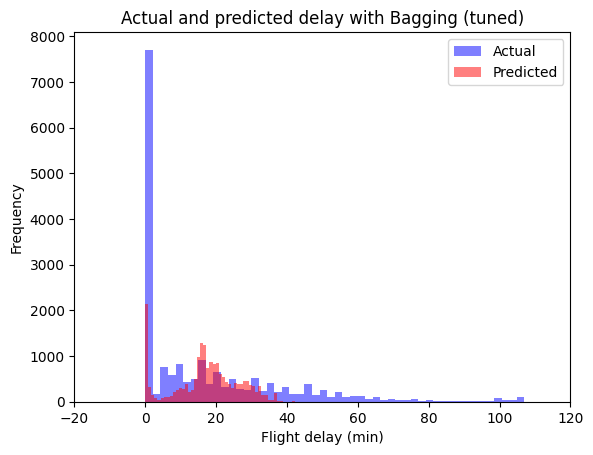

In [105]:
# # Plot predicted vs actual values
y_hat = bagging_reg.predict(X_test)

# Plot the histograms
plt.hist(y_test, bins=50, alpha=0.5, color='blue', label='Actual')
plt.hist(y_hat, bins=50, alpha=0.5, color='red', label='Predicted')

# Add labels and legend
plt.xlabel('Flight delay (min)')
plt.ylabel('Frequency')
plt.xlim(-20, 120)

plt.title('Actual and predicted delay with Bagging (tuned)')
plt.legend()

# Show plot
plt.show()

### Overfitting Check for the Ensemble Methods


In [107]:

# Function to check overfitting by comparing training and validation scores
def check_overfitting(model, X_train, y_train, X_test, y_test):
    # Predict on training data
    y_train_pred = model.predict(X_train)
    # Predict on test data
    y_test_pred = model.predict(X_test)
    
    # Calculate RMSE for training data
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    # Calculate RMSE for test data
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    
    print(f"Training RMSE: {rmse_train:.4f}")
    print(f"Test RMSE: {rmse_test:.4f}")
    print(f"Overfitting Check: {'Yes' if rmse_train < rmse_test else 'No'}")
    
    return rmse_train, rmse_test

# Random Forest (tuned)
print("Random Forest (tuned):")
check_overfitting(model_forest_reg, X_train, y_train, X_test, y_test)
print()

# Adaboost (tuned)
print("Adaboost (tuned):")
check_overfitting(model_ada_reg, X_train, y_train, X_test, y_test)
print()

# Bagging (tuned)
print("Bagging (tuned):")
check_overfitting(bagging_reg, X_train, y_train, X_test, y_test)
print()

Random Forest (tuned):
Training RMSE: 18.4798
Test RMSE: 19.0257
Overfitting Check: Yes

Adaboost (tuned):
Training RMSE: 19.2771
Test RMSE: 19.4368
Overfitting Check: Yes

Bagging (tuned):
Training RMSE: 19.1616
Test RMSE: 19.2772
Overfitting Check: Yes

